In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import ast
#!pip install mapie

In [2]:
balanced_corpus = pd.read_csv(f"data/balanced_corpus.csv", index_col=0).reset_index()
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=2, lowercase=True)
vect.fit(train.text.values)

# logistic regression
lr = Pipeline([('vect', vect), ('ref', LogisticRegression())])
lr.fit(train.text, train.area)

Pipeline(steps=[('vect',
                 TfidfVectorizer(analyzer='char', max_df=0.5, min_df=2,
                                 ngram_range=(2, 5))),
                ('ref', LogisticRegression())])

In [3]:
print (classification_report(test.area.values, lr.predict(test.text.values)))

                 precision    recall  f1-score   support

        Ήπειρος       0.20      0.22      0.21        23
        Αιτωλία       0.36      0.58      0.44        24
        Αμοργός       0.13      0.18      0.15        22
Ανατολική Θράκη       0.16      0.21      0.18        24
        Αρκαδία       0.20      0.16      0.18        31
          Αχαΐα       0.39      0.22      0.28        32
      Επτάνησος       0.34      0.65      0.45        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.05      0.05      0.05        22
          Θράκη       0.25      0.16      0.20        25
       Ιωάννινα       0.30      0.21      0.24        29
       Κάρπαθος       0.40      0.29      0.33        28
     Κεφαλληνία       0.14      0.11      0.12        27
          Κρήτη       0.35      0.27      0.30        30
         Κύπρος       0.72      0.75      0.73        24
         Λέσβος       0.41      0.58      0.48        24
        Λακωνία       0.12    

In [212]:
from mapie.classification import MapieClassifier
# fitting the conformity threshold
mapie_score = MapieClassifier(estimator=lr, cv="prefit", method="lac")
mapie_score.fit(dev.text.values, dev.area.values) 

MapieClassifier(cv='prefit',
                estimator=Pipeline(steps=[('vect',
                                           TfidfVectorizer(analyzer='char',
                                                           max_df=0.5, min_df=2,
                                                           ngram_range=(2, 5))),
                                          ('ref', LogisticRegression())]))

The correct class was in the conformed with accuracy: 0.98%


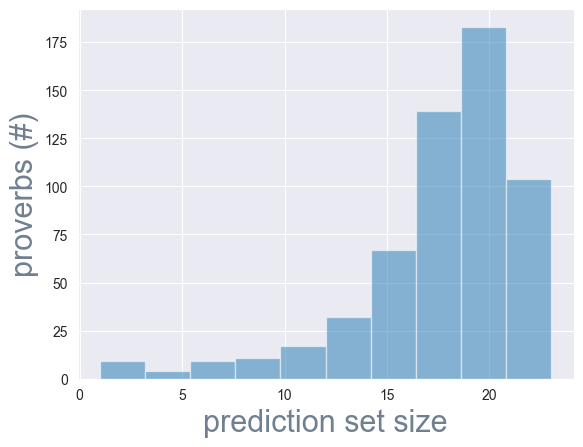

In [277]:
# assessing on to texts with known place of registration
y_pred_score, y_ps_score = mapie_score.predict(test.text.values, alpha=0.05)
conformed = [lr.classes_[y_ps_score[i].flatten()] for i in range(test.shape[0])]
test['conformed'] = conformed
print(f'The correct class was in the conformed with accuracy: {test.apply(lambda row: row.area in row.conformed, 1).mean():.2f}%')
ax = pd.Series(conformed).apply(len).hist(alpha=0.5);
ax.set_xlabel("prediction set size", color='slategrey', fontsize=22); ax.set_ylabel("proverbs (#)", fontsize=22, color='slategrey');
ax.get_figure().savefig('conformal_test.pdf', dpi=300, format='PDF')

In [214]:
# when the model was sure, that was Cyprus
test[test.conformed.apply(len)==1].conformed.explode().unique()

array(['Κύπρος'], dtype=object)

In [215]:
# when the model was not so sure, it was Cyprus, Amorgos, Eyvoia, and Skyros
test[test.conformed.apply(len)<5].conformed.explode().unique()

array(['Αμοργός', 'Κύπρος', 'Εύβοια', 'Σκύρος', 'Πόντος', 'Θράκη',
       'Λέσβος'], dtype=object)

## Geolocation of unregistered proverbs with conformal prediction

In [247]:
unregistered = pd.read_csv('data/unlocated.csv', index_col=0)
unregistered.sample()

,text,place,uri,collector,area
89224,Τον γράφω στη φτέρνα,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/176453,"Νεστορίδης, Κ.",Άδηλου τόπου


In [248]:
unregistered.shape[0]

3698

In [249]:
# removing 22 unregistered proverbs written in Italian or by using latin alphabet
valid_chars = {'Σ', '|', '–', 'η', '…', 'Ξ', '(', 'Δ', 'ό', 'τ', 'Ζ', 'ε', 'Ψ', 'Τ', 'Α','Ν', 'ι', '4', 'α', 'ω', 'φ', 'Υ', ':', '’', ')', 'o', 'θ', '0', 'Λ', '.', 'π', 'I', 'ο', 'ς', 'Ο', 'ύ', '1', 'Ί', '8', 'Ρ', '-', 'υ', 'Ό', '̇', '5', 'ή', 'ζ', '”', 'ΐ', 'Γ', 'Ι', 'β', 'Μ', 'ύ', '9', 'A', '!', '·', '«', 'Β', 'ϋ', 'ἰ', 'ν', 'μ', 'Η', 'ξ', ',', 'ϊ', 'λ', 'v', '·', 'χ', 'Π', 'Θ', 'Φ', 'ά', 'Ή', 'δ', 'κ', '“', 'Κ', ';', 'ώ', 'Χ', '[', ' ', 'Ύ', '+', 'σ', 'Ω', 'ΐ', 'Ε', ']', 'ί', 'ρ', '3', 'Έ', '"', 'ψ', '»', '΄', 'Ώ',  "'", 'γ', 'Ά', 'έ'}
unregistered = unregistered[unregistered.text.apply(lambda x: len(set(x)-valid_chars)==0)]
unregistered.shape[0]

3676

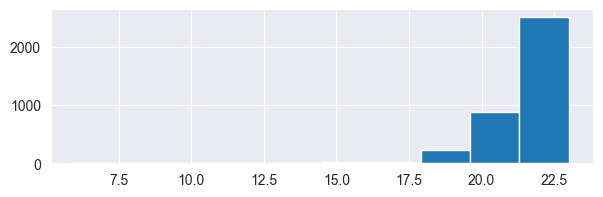

In [255]:
y_pred_score, y_ps_score = mapie_score.predict(unregistered.text.values, alpha=0.01)
unregistered['prediction_set'] = [lr.classes_[y_ps_score[i].flatten()] for i in range(unregistered.shape[0])]
unregistered.prediction_set.apply(len).hist(figsize=(7,2));

In [259]:
unregistered['prediction_set_size'] = unregistered.prediction_set.apply(len)
unregistered.sort_values(by='prediction_set_size', inplace=True)
unregistered[unregistered.prediction_set_size<12]

,text,place,uri,collector,area,prediction_set,prediction_set_size
77232,Αυτός είναι Παύλος,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/244693,"Μέγας, Γ.",Άδηλου τόπου,"[Αιτωλία, Αχαΐα, Επτάνησος, Θεσπρωτία, Θράκη, ...",6
42157,"Έδωκαν πρόσωπον τον Αλήν, κ' εσκώθεν κ' εσ' εσ...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/186222,"Καψάλης, Γεράσιμος",Άδηλου τόπου,"[Ήπειρος, Αμοργός, Επτάνησος, Ιωάννινα, Κάρπαθ...",10
97583,Αυτός είναι Ηρώδης,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/197857,"Παπατσώνης, Τάκης Κ.",Άδηλου τόπου,"[Αιτωλία, Αμοργός, Αρκαδία, Αχαΐα, Επτάνησος, ...",11
103540,Αυτός είναι κλαψομάρτης,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/278044,"Πουλάκης, Δημ.",Άδηλου τόπου,"[Ήπειρος, Αιτωλία, Αμοργός, Αρκαδία, Αχαΐα, Επ...",11
120305,Αν κανένας περάση νύχτα από το χωριό Δαμαλά τη...,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/294050,anonymous,Άδηλου τόπου,"[Ανατολική Θράκη, Αρκαδία, Αχαΐα, Επτάνησος, Ε...",11


#### Measuring the locations left out during the conformal prediction on the unregistered proverbs

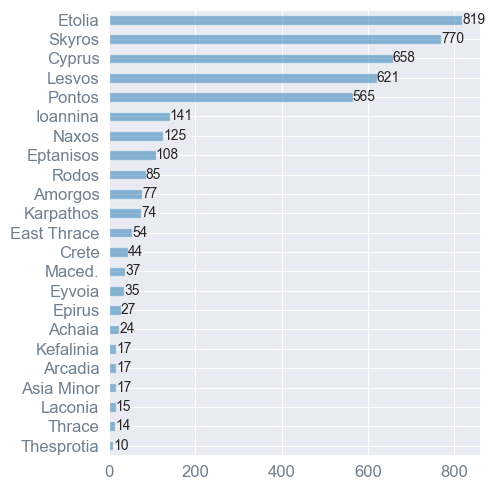

In [319]:
import seaborn as sns; sns.set_style('darkgrid')
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace', 'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia',  'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete', 'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor', 'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
regions = {'Πόντος', 'Κύπρος', 'Κάρπαθος', 'Θεσπρωτία', 'Αμοργός', 'Σκύρος', 'Μικρά Ασία', 'Λέσβος', 'Μακεδονία', 'Λακωνία', 'Εύβοια', 'Επτάνησος', 'Αρκαδία', 'Νάξος', 'Κρήτη', 'Αχαΐα', 'Θράκη', 'Ιωάννινα', 'Αιτωλία', 'Κεφαλληνία', 'Ανατολική Θράκη', 'Ρόδος', 'Ήπειρος'}
to_en = lambda grnames: {loc_name[x] for x in grnames}
ax = unregistered.prediction_set.apply(lambda x: list(to_en(regions)-to_en(x))).explode().value_counts(ascending=True).plot.barh(figsize=(5,5), alpha=0.5);
ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='slategrey')
ax.get_figure().tight_layout()
ax.bar_label(ax.containers[0])
ax.get_figure().savefig('excluded_areas.pdf', dpi=300, format='PDF')

In [323]:
unregistered[unregistered.prediction_set.apply(len)<10].iloc[0].prediction_set

array(['Αιτωλία', 'Αχαΐα', 'Επτάνησος', 'Θεσπρωτία', 'Θράκη', 'Νάξος'],
      dtype=object)

## Regression

In [179]:
el_reg_best_params = {'alpha': 0.0006167913176584872, 'l1_ratio': 0.7277034948352414}
el_reg = Pipeline([('vect', vect), ('reg', ElasticNet(**el_reg_best_params))])
el_reg.fit(train.text.values, train[["lat", "lon"]].values)

Pipeline(steps=[('vect',
                 TfidfVectorizer(analyzer='char', max_df=0.5, min_df=2,
                                 ngram_range=(2, 5))),
                ('reg',
                 ElasticNet(alpha=0.0006167913176584872,
                            l1_ratio=0.7277034948352414))])

In [186]:
from mapie.regression import MapieRegressor
mapie_regressor_lat = MapieRegressor(estimator=el_reg, method='plus')
mapie_regressor_lon = MapieRegressor(estimator=el_reg, method='plus')
mapie_regressor_lat.fit(dev.text.values, dev.lat.values) 
mapie_regressor_lon.fit(dev.text.values, dev.lon.values) 

MapieRegressor(estimator=Pipeline(steps=[('vect',
                                          TfidfVectorizer(analyzer='char',
                                                          max_df=0.5, min_df=2,
                                                          ngram_range=(2, 5))),
                                         ('reg',
                                          ElasticNet(alpha=0.0006167913176584872,
                                                     l1_ratio=0.7277034948352414))]))

In [187]:
y_pred_lat, y_pis_lat = mapie_regressor_lat.predict(test.text, alpha=0.05)
y_pred_lon, y_pis_lon = mapie_regressor_lon.predict(test.text, alpha=0.05)

In [188]:
rgp = pd.DataFrame({'latleft': y_pis_lat[:, 0].flatten(), 'latright': y_pis_lat[:, 1].flatten(),
                    'lonlow': y_pis_lon[:, 0].flatten(), 'lonhigh': y_pis_lon[:, 1].flatten()})
rgp['plat'] = y_pred_lat
rgp['plon'] = y_pred_lon
rgp['clat'] = test.lat.values
rgp['clon'] = test.lon.values

In [189]:
print(f'Lat acc: {rgp[(rgp.clat>rgp.latleft)&(rgp.clat<rgp.latright)].shape[0]/rgp.shape[0]:.2f}')

Lat acc: 0.97


In [190]:
print(f'Lon acc: {rgp[(rgp.clon>rgp.lonlow)&(rgp.clon<rgp.lonhigh)].shape[0]/rgp.shape[0]:.2f}')

Lon acc: 0.97


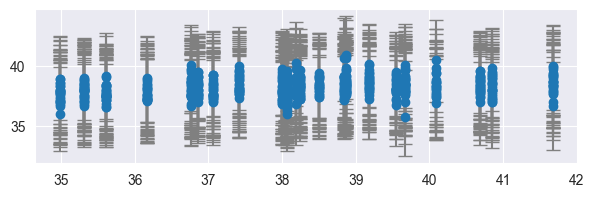

In [191]:
fig, ax = plt.subplots(figsize=(7, 2))
plt.errorbar(rgp.clat.values, rgp.plat, 
             yerr=(rgp.plat - rgp.latleft, rgp.latright-rgp.plat),
             ecolor='grey', linestyle='', marker = "o", capsize=5);
#ax.axline([0, 0], [1, 1], color = "red", linestyle='--', lw=3, zorder=3);

Now applying the calibrated conformal predictor to the unregistered proverbs

In [192]:
_, unr_pis_lat = mapie_regressor_lat.predict(unregistered.text, alpha=0.05)
_, unr_pis_lon = mapie_regressor_lon.predict(unregistered.text, alpha=0.05)

In [193]:
unregistered['conform_lat_left'] = unr_pis_lat[:, 0].flatten()
unregistered['conform_lat_right'] = unr_pis_lat[:, 1].flatten()
unregistered['conform_lon_low'] = unr_pis_lon[:, 0].flatten()
unregistered['conform_lon_high'] = unr_pis_lon[:, 1].flatten()

Conformal prediction geographical point sets are wide

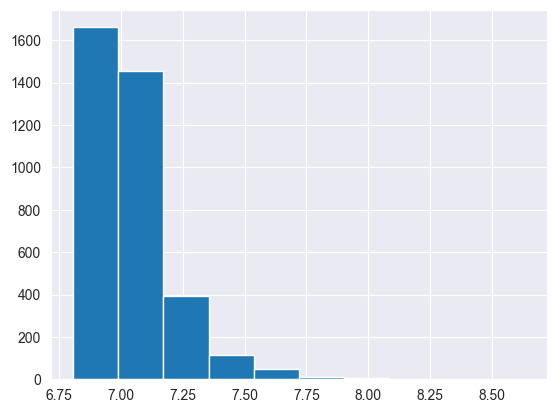

In [194]:
(unregistered.conform_lat_right-unregistered.conform_lat_left).hist();

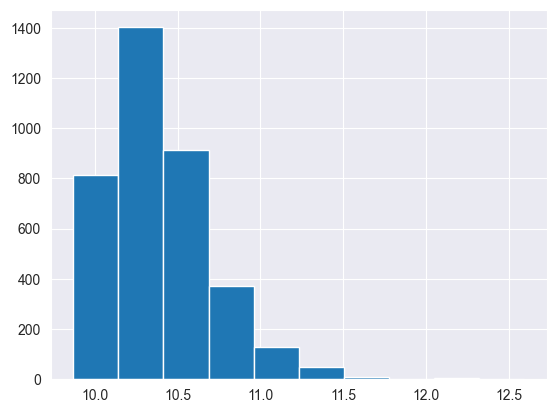

In [195]:
(unregistered.conform_lon_high-unregistered.conform_lon_low).hist();